### Train dnn_ctc with inp dim = 429 (context splicing)
Features :  (from kaldi - after applying CMVN)  
_data/train/train.scp_ , _data/train/train.ark_
_data/dev/dev.scp_ , _data/dev/dev.scp_
_data/test/test.scp_ , _data/test/test.scp_

Transcripts: (from kaldi)  
_data/train/text_ ,
_data/dev/text_ ,
_data/test/text_

In [2]:
import json
import os
import kaldiio
import numpy as np
import matplotlib.pyplot as plt
import itertools
import timeit
from jiwer import wer
import editdistance as ed

from torch.utils import data
import torch
import torch.nn as nn

import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

### Load the phoneme labels, prepare index to label and label to index mapping, label list for CTC decoding

In [3]:
#get all possible class labels
with open("train_nodev_units.txt", 'r') as f:
  lines = f.readlines()
lines = [ele.strip().split(' ') for ele in lines]
lines[0] = ['unk','1']
lines[1] = ['sil',' 2']

class_index_dict = {"blank": 0}
ctc_labels = []
ctc_labels.append('_')

for row in lines:
    ctc_labels.append(row[0])
    class_index_dict[row[0]] = int(row[1])

class_label_dict = {0: "blank"}
for row in lines:
    class_label_dict[int(row[1])] = row[0]
  
print(class_index_dict)
print(class_label_dict)
if 'unk' in class_index_dict:
  print("Found")
else: print("Not Found")
print(ctc_labels)

{'blank': 0, 'unk': 1, 'sil': 2, 'aa': 3, 'ae': 4, 'ah': 5, 'aw': 6, 'ay': 7, 'b': 8, 'ch': 9, 'd': 10, 'dh': 11, 'dx': 12, 'eh': 13, 'er': 14, 'ey': 15, 'f': 16, 'g': 17, 'hh': 18, 'ih': 19, 'iy': 20, 'jh': 21, 'k': 22, 'l': 23, 'm': 24, 'n': 25, 'ng': 26, 'ow': 27, 'oy': 28, 'p': 29, 'r': 30, 's': 31, 'sh': 32, 't': 33, 'th': 34, 'uh': 35, 'uw': 36, 'v': 37, 'w': 38, 'y': 39, 'z': 40}
{0: 'blank', 1: 'unk', 2: 'sil', 3: 'aa', 4: 'ae', 5: 'ah', 6: 'aw', 7: 'ay', 8: 'b', 9: 'ch', 10: 'd', 11: 'dh', 12: 'dx', 13: 'eh', 14: 'er', 15: 'ey', 16: 'f', 17: 'g', 18: 'hh', 19: 'ih', 20: 'iy', 21: 'jh', 22: 'k', 23: 'l', 24: 'm', 25: 'n', 26: 'ng', 27: 'ow', 28: 'oy', 29: 'p', 30: 'r', 31: 's', 32: 'sh', 33: 't', 34: 'th', 35: 'uh', 36: 'uw', 37: 'v', 38: 'w', 39: 'y', 40: 'z'}
Found
['_', 'unk', 'sil', 'aa', 'ae', 'ah', 'aw', 'ay', 'b', 'ch', 'd', 'dh', 'dx', 'eh', 'er', 'ey', 'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k', 'l', 'm', 'n', 'ng', 'ow', 'oy', 'p', 'r', 's', 'sh', 't', 'th', 'uh', 'uw', 'v

# Neural-net architecture

In [4]:
# Fully connected neural network with 4 hidden layer
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        
        self.dnn_layer1 = nn.Sequential(
            nn.Linear(429, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
            nn.Dropout(p=0.2, inplace=False)
          )
        
        self.dnn_layer2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
            nn.Dropout(p=0.2, inplace=False)
          )
        
        self.dnn_layer3 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
            nn.Dropout(p=0.2, inplace=False)
          )
        
        self.dnn_layer4 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True),
            nn.Dropout(p=0.2, inplace=False)
          )
        
        self.dnn_layer5 = nn.Sequential(
            nn.Linear(1024, 41)
          )
        self.log_softmax = nn.LogSoftmax(dim=1)
        
        
    def forward(self, x):
        x = self.dnn_layer1(x)
        x = self.dnn_layer2(x)
        x = self.dnn_layer3(x)
        x = self.dnn_layer4(x)
        x = self.dnn_layer5(x)
        x = self.log_softmax(x)
        return x

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
#device =  'cpu' 
print(device)
model = NeuralNet()
model.to(device)

cuda


NeuralNet(
  (dnn_layer1): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer2): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer3): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer4): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer5): Se

In [15]:
ctc_loss = nn.CTCLoss(reduction='sum')
learning_rate = 0.001
weight_decay = 0.0005
optimizer =  optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [16]:
def context_window(fea,left,right):
    N_row=fea.shape[0]
    N_fea=fea.shape[1]
    frames = np.empty((N_row-left-right, N_fea*(left+right+1)))
    for frame_index in range(left,N_row-right):
        right_context=fea[frame_index+1:frame_index+right+1].flatten() # right context
        left_context=fea[frame_index-left:frame_index].flatten() # left context
        current_frame=np.concatenate([left_context,fea[frame_index],right_context])
        frames[frame_index-left]=current_frame
    return frames

In [5]:
class TimitDataLoader(data.Dataset):
    def __init__(self, data_path,label_path):
        with open(data_path, 'r') as f:
            self.feat_data = f.readlines()
        
        self.feat_data = [ele.strip().split(" ") for ele in self.feat_data]
        self.feat_dict = {}
        
        self.utts = []
        for row in self.feat_data:
            self.utts.append(row[0])
            self.feat_dict[row[0]] = row[1:]
        
        with open(label_path) as f:
            self.label_list = f.readlines()

        self.label_list = [ele.strip().split(" ") for ele in self.label_list]
        self.label_dict = {}
        
        for row in self.label_list:
            self.label_dict[row[0]] = row[1:]
        
    def __len__(self):
        return len(self.utts)
    
    def __getitem__(self, index):
        
        inp_dir = "./cmvn_delta/"
        utt = self.utts[index]
        
        #print(utt)
        feat_file = inp_dir + self.feat_dict[utt][0]
        feats = kaldiio.load_mat(feat_file)
        feats = context_window(feats,5,5)
        #print(feats.shape)
        labels = self.label_dict[utt]
        #print(labels)
        labels = [class_index_dict[ele] for ele in labels]
        
        return (torch.from_numpy(feats), torch.LongTensor(labels), utt)

In [18]:
# train feats and transcript 
tr_data_path = "./cmvn_delta/data/train/train.scp"
tr_json_path = "./ctc_labels/train_text"
timit_train_data = TimitDataLoader(tr_data_path,tr_json_path)

# dev feats and transcript
dev_data_path = "./cmvn_delta/data/dev/dev.scp"
dev_json_path = "./ctc_labels/dev_text"
timit_dev_data = TimitDataLoader(dev_data_path,dev_json_path)

print(len(timit_train_data.utts))
print(len(timit_dev_data.utts))

4620
500


In [19]:
# compute train per
def compute_wer(index, input_sizes, targets, target_sizes):
    batch_errs = 0
    batch_tokens = 0
    for i in range(len(index)):
        label = targets[i][:target_sizes[i]]
        pred = []
        for j in range(len(index[i][:input_sizes[i]])):
            if index[i][j] == 0:
                continue
            if j == 0:
                pred.append(index[i][j])
            if j > 0 and index[i][j] != index[i][j-1]:
                pred.append(index[i][j])
        batch_errs += ed.eval(label, pred)
        batch_tokens += len(label)
    return batch_errs, batch_tokens

In [20]:
def run_epoch(epoch_id, model, data_iter, loss_fn, device, optimizer=None, is_training=True, batch_size=2):
    if is_training:
        model.train()
    else:
        model.eval()
    
    total_loss = 0
    total_tokens = 0
    total_errs = 0
    loss_sum = 0
    batch_cnt = 0
    num_batches = np.ceil(len(data_iter)/batch_size) # round to next high integer
    last_batch = False

    for i, data in enumerate(data_iter):
        inputs, input_sizes, targets, target_sizes, utt_list = data
        inputs = inputs.to(device)
        b_size, max_len, n_features = inputs.size()  # [batch_size, len, feat_size]
        inputs = inputs.view(max_len * b_size, -1)  # reshape  [frames, input_dim]
        
        
        input_sizes = input_sizes.to(device)
        targets = targets.to(device)
        target_sizes = target_sizes.to(device)
       
        out = model(inputs)
        out = out.view(max_len, b_size, -1)  # [len ,batch_size, num_classes]
        out_len, b_size, _ = out.size()
        input_sizes = (input_sizes * out_len).long()
        loss = loss_fn(out, targets, input_sizes, target_sizes)
        loss_sum = loss_sum + loss
        prob, index = torch.max(out, dim=-1)
        batch_errs, batch_tokens = compute_wer(index.transpose(0,1).cpu().numpy(), input_sizes.cpu().numpy(), 
                                                     targets.cpu().numpy(), target_sizes.cpu().numpy())
        total_errs += batch_errs
        total_tokens += batch_tokens

        if (i+1) % batch_size == 0:
            batch_cnt = batch_cnt + 1
            total_loss += loss_sum.item()
            if batch_cnt == num_batches:
                last_batch = True
                
            if is_training:    
                optimizer.zero_grad()
                loss_sum.backward()
                optimizer.step()
                loss_sum = 0
            else:
                loss_sum = 0
                
    if last_batch == False:
        batch_cnt = batch_cnt + 1
        total_loss += loss_sum.item()

        if is_training: 
            optimizer.zero_grad()
            loss_sum.backward()
            optimizer.step()
            
    average_loss = total_loss / (i+1)
    training = "Train" if is_training else "Valid"
    print("Epoch %d %s done, total_loss: %.4f, total_wer: %.4f" % (epoch_id, training, average_loss, total_errs / total_tokens))
    return 1-total_errs / total_tokens, average_loss

In [21]:
def pad_batch(DataLoaderBatch):
    """
    DataLoaderBatch should be a list of (sequence, target, utterance_id) tuples...
    Returns a padded tensor of sequences sorted from longest to shortest, 
    """
    inputs_max_length = max(x[0].size(0) for x in DataLoaderBatch)
    feat_size = DataLoaderBatch[0][0].size(1)
    targets_max_length = max(x[1].size(0) for x in DataLoaderBatch)
    batch_size = len(DataLoaderBatch)
    batch_data = torch.zeros(batch_size, inputs_max_length, feat_size) 
    batch_label = torch.zeros(batch_size, targets_max_length)
    input_sizes = torch.zeros(batch_size)
    target_sizes = torch.zeros(batch_size)
    utt_list = []

    for x in range(batch_size):
        feature, label, utt = DataLoaderBatch[x]
        feature_length = feature.size(0)
        label_length = label.size(0)

        batch_data[x].narrow(0, 0, feature_length).copy_(feature)
        batch_label[x].narrow(0, 0, label_length).copy_(label)
        input_sizes[x] = feature_length / inputs_max_length
        target_sizes[x] = label_length
        utt_list.append(utt)
    return batch_data.float(), input_sizes.float(), batch_label.long(), target_sizes.long(), utt_list 

In [22]:
training_generator = data.DataLoader(dataset=timit_train_data,
                                        batch_size=1,shuffle=True,
                                        collate_fn=pad_batch) # use custom collate function here

validation_generator = data.DataLoader(dataset=timit_dev_data,
                                        batch_size=1,shuffle=True,
                                        collate_fn=pad_batch) # use custom collate function here


In [23]:
out_folder = 'ctc_cmvn_context_size8/'

# Create the output folder
try:
    os.stat(out_folder)
except:
    os.makedirs(out_folder)

# Creating the res file 
res_file = open(out_folder + 'results.res',"w")

In [24]:
tr_loss_per_epoch = []
dev_loss_per_epoch = []

tr_acc_per_epoch = []
dev_acc_per_epoch = []

epoch = 0
n_epochs = 35

In [25]:
while epoch < n_epochs:
    
    epoch = epoch + 1
   
    start_epoch=timeit.default_timer()    
    print("Start training epoch: %d, learning_rate: %.5f" % (epoch, learning_rate))
    
    train_acc, train_loss = run_epoch(epoch, model, training_generator, ctc_loss, device, 
                                      optimizer=optimizer, is_training=True, batch_size=8)
    tr_loss_per_epoch.append(train_loss)
    tr_acc_per_epoch.append(train_acc)
    
    dev_acc, dev_loss = run_epoch(epoch, model, validation_generator, ctc_loss, device, 
                                  optimizer=None, is_training=False, batch_size=8)
    
    dev_loss_per_epoch.append(dev_loss)
    dev_acc_per_epoch.append(dev_acc)
    
    if (epoch % 5) == 0:
        torch.save({'epoch': epoch,'model_state_dict': model.state_dict(),'optimizer_state_dict': optimizer.state_dict(),
                    'tr_loss_per_epoch' : tr_loss_per_epoch,'tr_acc_per_epoch' : tr_acc_per_epoch,
                    'dev_loss_per_epoch': dev_loss_per_epoch,'dev_acc_per_epoch': dev_acc_per_epoch}, out_folder + 'model_ep' + str(epoch) + '.pkl')
    
    res_file.write('epoch %i training_loss=%f,training_WER=%f,validation_loss=%f,validation_WER=%f\n'
          %(epoch,train_loss,train_acc,dev_loss,dev_acc))
    
    end_epoch=timeit.default_timer()

print('Done')

Start training epoch: 1, learning_rate: 0.00100
Epoch 1 Train done, total_loss: 114.7711, total_wer: 0.7875
Epoch 1 Valid done, total_loss: 67.7857, total_wer: 0.5545
Start training epoch: 2, learning_rate: 0.00100
Epoch 2 Train done, total_loss: 55.6216, total_wer: 0.4655
Epoch 2 Valid done, total_loss: 44.7552, total_wer: 0.3849
Start training epoch: 3, learning_rate: 0.00100
Epoch 3 Train done, total_loss: 44.7312, total_wer: 0.3686
Epoch 3 Valid done, total_loss: 40.6837, total_wer: 0.3539
Start training epoch: 4, learning_rate: 0.00100
Epoch 4 Train done, total_loss: 39.9299, total_wer: 0.3336
Epoch 4 Valid done, total_loss: 39.1297, total_wer: 0.3335
Start training epoch: 5, learning_rate: 0.00100
Epoch 5 Train done, total_loss: 37.1096, total_wer: 0.3119
Epoch 5 Valid done, total_loss: 36.0952, total_wer: 0.3078
Start training epoch: 6, learning_rate: 0.00100
Epoch 6 Train done, total_loss: 35.0962, total_wer: 0.2979
Epoch 6 Valid done, total_loss: 36.0970, total_wer: 0.2928
Sta

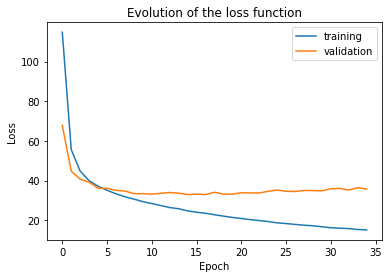

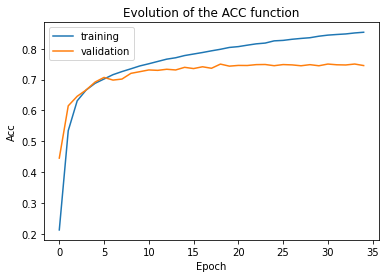

In [27]:
# plot the loss and PER curves
plt.figure()
plt.plot(tr_loss_per_epoch, label='training')
plt.plot(dev_loss_per_epoch,label='validation')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Evolution of the loss function")
plt.legend()
plt.savefig(out_folder + "loss.png")

plt.figure()
plt.plot(tr_acc_per_epoch, label='training')
plt.plot(dev_acc_per_epoch,label='validation')
plt.ylabel("Acc")
plt.xlabel("Epoch")
plt.title("Evolution of the ACC function")
plt.legend()
plt.savefig(out_folder + "acc.png")

In [28]:
# Load model with best validation accuracy 
out_folder = 'ctc_cmvn_context_size8/'
checkpoint = torch.load(out_folder + 'model_ep25.pkl')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
tr_loss_per_epoch = checkpoint['tr_loss_per_epoch']
dev_loss_per_epoch = checkpoint['dev_loss_per_epoch']
tr_acc_per_epoch = checkpoint['tr_acc_per_epoch']
dev_acc_per_epoch = checkpoint['dev_acc_per_epoch']
model.to(device)

NeuralNet(
  (dnn_layer1): Sequential(
    (0): Linear(in_features=429, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer2): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer3): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer4): Sequential(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
  )
  (dnn_layer5): Se

In [29]:
# test feats and transcripts
test_data_path = "./cmvn_delta/data/test/test.scp"
test_json_path = "./ctc_labels/test_text"

timit_test_data = TimitDataLoader(test_data_path,test_json_path)

testing_generator = data.DataLoader(timit_test_data)


In [30]:
# Initiate CTC Prefix decoder
from pytorch_end2end import CTCDecoder
decoder = CTCDecoder(blank_idx=0, beam_width=100, time_major=False,after_logsoftmax=True,labels=ctc_labels)

In [31]:
# CTC-decoding of test utterances and determine PER
with torch.no_grad():  
    total = 0
    per = 0
    for x, y, z in testing_generator:
        total = total + 1
        x = x.view(x.shape[1],x.shape[2])
        x = x.float().to(device)
        target = [item for t in y for item in t.numpy()]
        target_label = [class_label_dict[ele] for ele in target]
        #y = [class_index_dict[ele[0]] for ele in y]
        #targets = torch.from_numpy(np.asarray(y))
        outputs = model(x)
        output_lengths = torch.tensor([outputs.shape[0]])
        outputs = outputs.view(1,outputs.shape[0],-1)
        
        #predicteds = net(inputs)
        decoded_targets, decoded_targets_lengths, decoded_sentences = decoder.decode(outputs, output_lengths)
        pred_index = decoded_targets.view(decoded_targets.shape[1]).tolist()
        pred_label = [class_label_dict[ele] for ele in pred_index]
        per = per + wer(target_label,pred_label)
    
    print(total)
    print('PER of the network on test utterances: {} %'.format(100 * per / total))
    res_file.write('PER of the network on test utterances: {} %'.format(100 * per / total))
    
res_file.close()
print('Done')

240
PER of the network on test utterances: 26.010764160821548 %
Done
